# Machine Learning Analyse – Servicedesk Wire Solutions
In dit notebook staan **beide machine learning-analyses** uit het onderzoek:

1. **Supervised learning – Tekstclassificatie**
   - Voorspellen van de hoofdafdeling op basis van de tekst in *"Beschrijving incident"*.
   - Hoort bij: Bijlage 3.1 – Supervised Machine Learning.

2. **Unsupervised learning – Topic Modelling**
   - Automatisch ontdekken van inhoudelijke thema's in incidentbeschrijvingen.
   - Hoort bij: Bijlage 3.2 – Unsupervised Machine Learning.

Het doel van dit notebook is transparant laten zien **welke stappen in Python zijn gezet**, zodat de analyses reproduceerbaar zijn.

**Packages installeren (indien nodig)**
Voer deze cel alleen uit als je de packages nog niet geïnstalleerd hebt.

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk pyLDAvis


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**1. Imports en basisinstellingen**

Deze imports worden door beide delen (supervised + unsupervised) gebruikt.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

pd.set_option("display.max_colwidth", 200)
plt.style.use("default")
sns.set(style="whitegrid")

# DEEL A – Supervised Machine Learning
In dit deel wordt onderzocht of een **classificatiemodel** in staat is om
de **hoofdafdeling** van een incident te voorspellen op basis van de tekst
in *"Beschrijving incident"*.

**Belangrijkste vragen:**

- Hoe goed kan een model op basis van tekst de juiste afdeling raden?
- Is de voorspellende kracht goed genoeg om ontbrekende afdelingen betrouwbaar aan te vullen?

**2A. Data inladen (tekstclassificatie)**

We gebruiken het bestand:
- 'onbekende-afdelingen voorspellen.csv'
met o.a.:
- 'incident nummer'
- 'Beschrijving incident'
- 'hoofd afdelingen'

In [3]:
df_cls = pd.read_csv("onbekende-afdelingen voorspellen.csv", sep=",")

print("Vorm van de dataset:", df_cls.shape)
df_cls.head()

Vorm van de dataset: (25758, 3)


,incident nummer,Beschrijving incident,hoofd afdelingen
0,1235359,zwarte Dell boxen plaatsen op kantoor Nierdialyse i.o.m. Karel van de Berg,Marketing
1,1240645,"zwart scherm, error logging in code 70",Commercial department
2,1240473,"Zwart scherm, dus ook het tweede inbouwscherm doet het nu niet (blijft eveneens opzwart staat) melding no signal",Commercial department
3,1210261,Zwart scherm nog voor het inloggen,Production A
4,1224306,Zwart scherm na uitloggen,HR advies


**3A. Bekende vs. onbekende afdelingen scheiden**

Het model kan alleen leren van incidenten waar de afdeling **bekend** is.
We splitsen de data daarom op in:
- `bekend`: incidente met een bekende 'hoofd afdelingen'
- `onbekend`: incidenten met een onbekende / lege afdeling

In [4]:
onbekend_waarden = ["Onbekend"]

bekend = df_cls[~df_cls["hoofd afdelingen"].isin(onbekend_waarden)].copy()
onbekend = df_cls[df_cls["hoofd afdelingen"].isin(onbekend_waarden)].copy()

print("Aantal bekende afdelingen:", bekend.shape[0])
print("Aantal onbekende afdelingen:", onbekend.shape[0])

Aantal bekende afdelingen: 23838
Aantal onbekende afdelingen: 1920


**4A. Train–test split**

We gebruiken:
- **Input (X)**: tekst in 'Beschrijving incident'
- **Label (y)**: 'hoofd afdelingen'

 Met `train_test_split` maken we een train- en testset:
- 80% train
- 20% test

`stratify=y` zorgt ervoor dat de verdeling van afdelingen in beide sets vergelijkbaar blijft.

In [5]:
# Verwijder rijen zonder beschrijving of zonder afdeling
bekend_clean = bekend.dropna(subset=["Beschrijving incident", "hoofd afdelingen"]).copy()

X = bekend_clean["Beschrijving incident"]
y = bekend_clean["hoofd afdelingen"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Train set:", len(X_train))
print("Test set:", len(X_test))

Train set: 19065
Test set: 4767


**5A. Pipeline: TF-IDF + Logistic Regression**

We bouwen een sklearn `Pipeline` met twee stappen:
1. **TF-IDF vectorisatie**
Zet tekst om naar numerieke kenmerken op basis van termfrequentie.
2. **Logistic Regression classifier**
Voert de daadwerkelijke voorspelling van de afdeling uit.

Voordeel van een pipeline:
- de volledige tekst-verwerking en het model zitten in één object;
- minder kans op fouten en makkelijker reproduceerbaar.

In [6]:
pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                ngram_range=(1, 2),     # 1-grams en 2-grams
                min_df=2,               # negeer woorden die maar één keer voorkomen
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=200,
                n_jobs=-1,
            ),
        ),
    ]
)

**6A. Model trainen en eerste evaluatie**

We trainen de pipeline op de trainingsdata en evalueren vervolgens op de testset.
Belangrijke metrics:
- Accuracy
- Precision, Recall, F1-score (macro)
- Een classificatierapport per afdeling

In [7]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy op de testset: {acc:.3f}\n")

print("Classificatierapport:\n")
print(classification_report(y_test, y_pred))

Accuracy op de testset: 0.400

Classificatierapport:

                       precision    recall  f1-score   support

Commercial department       0.39      0.67      0.50      1563
  Facility management       0.36      0.07      0.12       215
            HR advies       0.75      0.06      0.10       163
            Marketing       0.39      0.12      0.19       522
               Overig       0.53      0.03      0.05       317
         Production A       0.42      0.53      0.47      1356
        Production QA       0.29      0.06      0.10       631

             accuracy                           0.40      4767
            macro avg       0.45      0.22      0.22      4767
         weighted avg       0.41      0.40      0.34      4767



**7A. Confusion matrix**

De confusion matrix laat zien **hoe vaak het model per afdeling goed of fout zit**.
Dit is nuttig om te zien:
- welke afdelingen vaak door elkaar worden gehaald;
- of er afdelingen zijn die bijna nooit (goed) herkend worden.

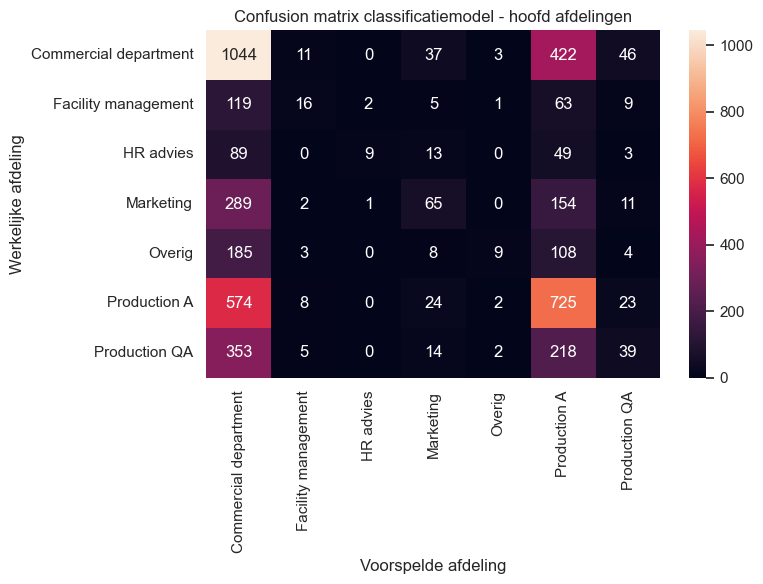

In [8]:
labels = pipeline.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Voorspelde afdeling")
plt.ylabel("Werkelijke afdeling")
plt.title("Confusion matrix classificatiemodel - hoofd afdelingen")
plt.tight_layout()
plt.show()

**8A. Drempelanalyse (modelzekerheid)**

Het model geeft voor elke afdeling een **kans** (`predict_proba`).
In plaats van altijd de hoogste kans te kiezen, kunnen we zeggen:
> "Alleen voorspellingen met een kans boven drempel T accepteren."

Zo ontstaat een balans tussen:
- **dekking (coverage)**: hoeveel incidenten voorspellen we nog?
- **kwaliteit**: hoe goed zijn de voorspellingen die overblijven?

In [22]:
# Kansverdeling voor de testset
y_test_proba = pipeline.predict_proba(X_test)
classes = pipeline.classes_

def evaluate_thresholds(y_true, y_proba, classes, thresholds):
    """
    Berekent voor elke drempel:
    - aantal voorspellingen (coverage)
    - precision, recall en f1-score (macro)

    Alles onder de drempel wordt behandeld als 'geen voorspelling'.
    """
    y_true = np.array(y_true)
    results = []

    best_idx = y_proba.argmax(axis=1)
    best_prob = y_proba.max(axis=1)
    best_class = classes[best_idx].astype(object)

    for t in thresholds:
        pred = best_class.copy()
        pred[best_prob < t] = None

        mask = pred != None

        if mask.sum() == 0:
            results.append([t, 0, 0.0, 0.0, 0.0])
            continue

        true_filtered = y_true[mask]
        pred_filtered = pred[mask]

        precision = precision_score(true_filtered, pred_filtered, average="macro", zero_division=0)
        recall    = recall_score(true_filtered, pred_filtered, average="macro", zero_division=0)
        f1        = f1_score(true_filtered, pred_filtered, average="macro", zero_division=0)
        coverage  = int(mask.sum())

        results.append([t, coverage, precision, recall, f1])

    cols = ["drempel", "aantal_voorspeld", "precision", "recall", "f1"]
    return pd.DataFrame(results, columns=cols)

# Tabel met drempelwaarden
thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

df_thresholds = evaluate_thresholds(y_test, y_test_proba, classes, thresholds)
df_thresholds

,drempel,aantal_voorspeld,precision,recall,f1
0,0.50,1044,0.459844,0.295961,0.296348
1,0.55,692,0.478978,0.325050,0.334750
2,0.60,429,0.368740,0.253685,0.231996
3,0.65,278,0.261321,0.248242,0.231915
4,0.70,156,0.259231,0.251905,0.240000
5,0.75,67,0.356725,0.273384,0.293564
6,0.80,23,0.633333,0.583333,0.601504
7,0.85,10,0.450000,0.500000,0.473684
8,0.90,4,1.000000,1.000000,1.000000


**9A. Model toepassen op onbekende afdelingen**

Met de gekozen drempel (bijvoorbeeld 0.60 of 0.80) bekijken we:
- hoeveel *onbekende* incidenten alsnog een betrouwbare afdeling krijgen;
- welk deel onbekend blijft.

Dit sluit aan bij de paragraaf in het rapport over het beperkte effect
van verrijking met ML.

In [20]:
# Kies een drempel (bijv. 0.60) voor toepassing op onbekende incidenten
drempel = 0.80

if not onbekend.empty:
    onbekend_proba = pipeline.predict_proba(onbekend["Beschrijving incident"])
    best_idx = onbekend_proba.argmax(axis=1)
    best_class = classes[best_idx]
    best_proba = onbekend_proba.max(axis=1)

    # Alleen voorspellingen boven de drempel gebruiken
    mask = best_proba >= drempel

    onbekend["voorspelde_afdeling"] = None
    onbekend.loc[mask, "voorspelde_afdeling"] = best_class[mask]

    print("Totaal onbekend:", onbekend.shape[0])
    print("Aantal aangevuld met drempel", drempel, ":", mask.sum())
    print(
        "Percentage aangevuld:",
        (mask.sum() / max(1, onbekend.shape[0])) * 100,
    )
else:
    print("Er zijn geen onbekende afdelingen in deze dataset.")

Totaal onbekend: 1920
Aantal aangevuld met drempel 0.8 : 8
Percentage aangevuld: 0.4166666666666667


### 10A. Conclusie supervised model

Op basis van de resultaten in dit notebook blijkt dat:

- De overall performance (accuracy, F1-score) **beperkt** is.
- Bij hogere drempels (meer zekerheid) blijft slechts een **heel klein deel**
  van de incidenten over waarvoor het model een voorspelling durft te doen.
- Het effect op de totale dataset is daardoor minimaal: maar een paar procent
  van de onbekende afdelingen kan met voldoende zekerheid worden ingevuld.

Daarom is besloten het model **niet** te gebruiken voor automatische verrijking,
maar alleen als **inzicht** in de beperkingen van tekstclassificatie bij
inconsistente en generieke incidentbeschrijvingen.


# DEEL B – Unsupervised Machine Learning (Topic Modelling)

In dit tweede deel wordt geen label voorspeld, maar wordt juist gekeken
welke **thema's vanzelf ontstaan** in de incidentbeschrijvingen.
Hiervoor gebruiken we **LDA-topic modelling**.

Doelen:
- Onderliggende inhoudelijke thema's ontdekken.
- Per incident een `topic_id` en `topic_label` bepalen.
- Deze thema's gebruiken in Power BI voor analyses van werkdruk en SLA.

**1B. Data inladen voor topic modelling**

We gebruiken het bestand:
- 'textmining_beschrijving-incident.csv'
met o.a.:
- 'incident nummer'
- 'Beschrijving incident'

We maken eerst een kolom 'beschrijving_clean' met opgeschoonde tekst.

In [11]:
df_tm = pd.read_csv("textmining_beschrijving-incident.csv")

print("Vorm dataset:", df_tm.shape)
df_tm.head()

df_tm = df_tm.dropna(subset=["Beschrijving incident"]).copy()
df_tm["beschrijving_clean"] = df_tm["Beschrijving incident"].str.lower()

print("Aantal incidenten na opschonen:", df_tm.shape[0])
df_tm[["Beschrijving incident", "beschrijving_clean"]].head()

Vorm dataset: (25758, 3)
Aantal incidenten na opschonen: 25752


,Beschrijving incident,beschrijving_clean
0,Nieuwe KA: ctxh21-02 geen beschikbare servers,nieuwe ka: ctxh21-02 geen beschikbare servers
1,TC loopt met enige regelmaat vast of hapert,tc loopt met enige regelmaat vast of hapert
2,Kaartlezer wordt niet offline ondersteund.,kaartlezer wordt niet offline ondersteund.
3,"iTask, rechten herstellen","itask, rechten herstellen"
4,"Process Manager, Ondersteuning uitwerking proces","process manager, ondersteuning uitwerking proces"


**2B. Stopwoorden- en ruiswoordenlijst opstellen**

Hier bouwen we een **stopwoordenlijst** die bestaat uit:
- standaard Nederlandse stopwoorden;
- veelvoorkomende korte woorden in deze dataset;
- specifieke 'ruiswoorden' zoals algemene begroetingen of organisatienamen.

Daarna gebruiken we deze lijst in de `CountVectorizer`.

In [12]:
def tokenize(text):
    """Eenvoudige tokenizer: alleen woorden met letters, lengte >= 2."""
    return re.findall(r"\b[a-zA-Z]{2,}\b", str(text).lower())

# 1. Alle woorden uit de incidentbeschrijvingen ophalen
all_words = []
for txt in df_tm["Beschrijving incident"]:
    all_words.extend(tokenize(txt))

word_freq = Counter(all_words)
print("Aantal unieke woorden in corpus:", len(word_freq))

# 2. Meest voorkomende woorden bekijken (check / debug)
print("Top 30 meest voorkomende woorden:")
print(word_freq.most_common(30))

# 3. Dynamisch ruiswoorden uit de top-N frequentste woorden
most_common_words = [w for w, c in word_freq.most_common(150)]

generic_high_freq = [
    "geen", "goed", "werkt", "gaat", "blijft", "nieuwe", "nog",
    "uit", "over", "komt", "geeft", "vraag", "vraagt", "gevraagd",
    "probleem", "problemen", "status"
]

dynamic_noise = []

for w in most_common_words:
    if len(w) < 3: dynamic_noise.append(w)      # korte woorden
    if w.isdigit(): dynamic_noise.append(w)     # pure cijfers
    if w in generic_high_freq: dynamic_noise.append(w)

# 4. Algemene Nederlandse stopwoorden
dutch_stopwords = [
    "de", "het", "een", "en", "of", "maar", "want", "dus",
    "van", "op", "aan", "in", "met", "onder", "boven",
    "voor", "achter", "naar", "tussen", "bij", "tot",
    "dat", "dit", "die", "daar", "hier", "als", "dan",
    "ik", "je", "jij", "u", "wij", "we", "jullie", "zij",
    "er", "is", "was", "zijn", "worden", "wordt", "heeft",
    "hebben", "doet", "kan", "kunnen", "zal", "zullen",
    "moet", "moeten", "ook", "niet", "meer", "nog",
    "al", "toch", "wel", "om", "wil", "kan"
]

# 5. Domeinspecifieke servicedesk-ruis
domain_noise = [
    "wire", "solutions", "wiresolutions", "ws",
    "service", "desk", "servicedesk",
    "incident", "melding", "ticket",
    "kantoor", "amsterdam",
    "hallo", "goedemorgen", "goedemiddag",
    "svp", "graag",
    "user", "gebruiker", "gebruikers", "the", "weer"
]

# 6. Finale stopwoordenlijst
final_stopwords = sorted(set(dutch_stopwords + domain_noise + dynamic_noise))

print("\nTotaal aantal stopwoorden:", len(final_stopwords))
print("Voorbeeld stopwoorden:", final_stopwords[:40])

Aantal unieke woorden in corpus: 9213
Top 30 meest voorkomende woorden:
[('niet', 5095), ('cs', 3913), ('kan', 2015), ('in', 1787), ('met', 1768), ('op', 1734), ('dv', 1640), ('de', 1523), ('van', 1240), ('geen', 1236), ('is', 1170), ('inloggen', 1153), ('naar', 1040), ('nieuwe', 1024), ('wire', 980), ('outlook', 980), ('en', 913), ('mf', 880), ('het', 878), ('erp', 859), ('bij', 834), ('solutions', 822), ('een', 817), ('toevoegen', 759), ('agenda', 754), ('ziscon', 748), ('vraagt', 688), ('meer', 676), ('crm', 672), ('voor', 662)]

Totaal aantal stopwoorden: 108
Voorbeeld stopwoorden: ['aan', 'achter', 'al', 'als', 'amsterdam', 'bij', 'blijft', 'boven', 'cs', 'daar', 'dan', 'dat', 'de', 'desk', 'die', 'dit', 'doet', 'dus', 'dv', 'een', 'en', 'er', 'gaat', 'gebruiker', 'gebruikers', 'geeft', 'geen', 'gevraagd', 'goed', 'goedemiddag', 'goedemorgen', 'graag', 'hallo', 'hebben', 'heeft', 'het', 'hier', 'ik', 'in', 'incident']


**3B. Vectorisatie met CountVectorizer**

Met `CountVectorizer` zetten we de opgeschoonde beschrijvingen om in
een **document-termenmatrix (DTM)**:
- rijen = incidenten
- kolommen = woorden
- cellen = aantallen (hoe vaak komt een woord voor in een incident)

We beperken ons tot woorden die:
- minstens 5 keer voorkomen (`min_df=5`);
- niet in meer dan 90% van de documenten voorkomen (`max_df=0.90`).

In [13]:
stopword_list = list(final_stopwords)

vectorizer = CountVectorizer(
    max_df=0.90,
    min_df=5,
    stop_words=stopword_list,
)

dtm = vectorizer.fit_transform(
    df_tm["beschrijving_clean"].astype(str)
)

print("DTM vorm (docs, features):", dtm.shape)

DTM vorm (docs, features): (25752, 2275)


**4B. LDA-topicmodel trainen**

We trainen een **LDA-model** met 4 topics.
- `n_components=4` → we verwachten 4 inhoudelijke thema's.
- `random_state=42` → reproduceerbaar resultaat.

Het model leert:
- welke woorden bij welk topic horen;
- hoe sterk elk incident aan elk topic is gekoppeld.

In [14]:
n_topics = 4

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch",
)

lda.fit(dtm)

,n_components,4
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


**5B. Topics inspecteren (topwoorden)**

Om de topics te kunnen interpreteren, tonen we per topic de belangrijkste woorden.

In [15]:
feature_names = vectorizer.get_feature_names_out()

def toon_topics(model, feature_names, n_top_words=10):
    for i, topic in enumerate(model.components_):
        print(f"\nTopic {i}:")
        top_idx = topic.argsort()[:-n_top_words - 1:-1]
        print(", ".join([feature_names[j] for j in top_idx]))

toon_topics(lda, feature_names)


Topic 0:
inloggen, erp, crm, laptop, document, pas, handset, printer, activeren, printen

Topic 1:
aanpassen, rechten, opname, connect, scherm, foutmelding, beeld, doorverbonden, start, eskion

Topic 2:
outlook, account, ziscon, vast, mail, handtekening, telefoon, openen, loopt, mist

Topic 3:
toevoegen, agenda, stamtabel, tokencode, wachtwoord, verwijderen, safewordcode, code, vergeten, token


**6B. Dominant topic per incident bepalen**

Met `lda.transform(dtm)` krijgen we voor elk incident een verdeling
over de 4 topics (som = 1).

We kiezen per incident het topic met de hoogste waarschijnlijkheid
als **dominant topic** en slaan die op in `topic_id`.

In [16]:
doc_topic_dist = lda.transform(dtm)
df_tm["topic_id"] = doc_topic_dist.argmax(axis=1)

df_tm[["incident nummer", "beschrijving_clean", "topic_id"]].head()

,incident nummer,beschrijving_clean,topic_id
0,1065298,nieuwe ka: ctxh21-02 geen beschikbare servers,0
1,1124826,tc loopt met enige regelmaat vast of hapert,2
2,1156332,kaartlezer wordt niet offline ondersteund.,3
3,1183663,"itask, rechten herstellen",1
4,1183923,"process manager, ondersteuning uitwerking proces",0


**7B. Topic ID omzetten naar leesbare labels**

We mappen de numerieke `topic_id` naar beschrijvende, domein-neutrale labels.
Deze labels zijn afgestemd op de interpretatie uit het onderzoeksrapport.

In [17]:
topic_labels = {
    0: "Werkplek & Functionele Bedrijfsapplicaties",
    1: "Gebruikersbeheer & Autorisatieprocessen",
    2: "Toegang & Communicatieplatforms",
    3: "Bedrijfsapplicaties & Productiviteitsprocessen",
}

df_tm["topic_label"] = df_tm["topic_id"].map(topic_labels)

df_tm[["incident nummer", "topic_id", "topic_label"]].head(10)

,incident nummer,topic_id,topic_label
0,1065298,0,Werkplek & Functionele Bedrijfsapplicaties
1,1124826,2,Toegang & Communicatieplatforms
2,1156332,3,Bedrijfsapplicaties & Productiviteitsprocessen
3,1183663,1,Gebruikersbeheer & Autorisatieprocessen
4,1183923,0,Werkplek & Functionele Bedrijfsapplicaties
5,1188361,0,Werkplek & Functionele Bedrijfsapplicaties
6,1188362,0,Werkplek & Functionele Bedrijfsapplicaties
7,1188366,0,Werkplek & Functionele Bedrijfsapplicaties
8,1188368,2,Toegang & Communicatieplatforms
9,1188370,0,Werkplek & Functionele Bedrijfsapplicaties


**8B. Voorbeeldincidenten per topic (sanity check)**

We print voor elk topic een paar voorbeeldincidenten.
Dit is een **kwalitatieve controle**:

- Klopt het dat de incidenten binnen een topic inhoudelijk bij elkaar horen?
- Sluiten de labels aan bij de daadwerkelijke tekst?

In [18]:
for t in sorted(df_tm["topic_id"].unique()):
    print(f"\n=== Topic {t} - {topic_labels[t]} ===")
    voorbeelden = df_tm[df_tm["topic_id"] == t]["Beschrijving incident"].head(5)
    for i, txt in enumerate(voorbeelden, start=1):
        print(f"{i}. {str(txt)[:200]}")


=== Topic 0 - Werkplek & Functionele Bedrijfsapplicaties ===
1. Nieuwe KA: ctxh21-02 geen beschikbare servers
2. Process Manager, Ondersteuning uitwerking proces
3. CS Document: vraag
4. E-verwijzen
5. Probleem met inloggen in Dermamate

=== Topic 1 - Gebruikersbeheer & Autorisatieprocessen ===
1. iTask, rechten herstellen
2. Pos artsen CS
3. Gebruiker kan USB stick niet gebruiken
4. CS Opname: POS onderzoek printen
5. Aanvraag voor Mobile Inlog en WS Private. Hoe te installeren?

=== Topic 2 - Toegang & Communicatieplatforms ===
1. TC loopt met enige regelmaat vast of hapert
2. wire solutions kan geen pakketkeuze maken, heeft alleen  radio
3. CS Ziscon: autorisatie WOOLDE
4. CS Agenda: toevoegeing aan huis prikken
5. ipad: Mist iets op zijn ipad

=== Topic 3 - Bedrijfsapplicaties & Productiviteitsprocessen ===
1. Kaartlezer wordt niet offline ondersteund.
2. CS Agenda: Inrichting agenda's handenteam
3. CS-GGZ: dbs's zonder ......
4. CS Agenda: brief
5. CS Agenda: GGZ vraag ongepland 

**9B. Export voor Power BI**

De verrijkte dataset wordt opgeslagen zodat deze in Power BI gebruikt kan worden.
Belangrijke extra kolommen:
- `topic_id`
- `topic_label`

In [19]:
df_tm.to_csv("incidentdata_with_topics.csv", index=False)
print("Bestand opgeslagen: incidentdata_with_topics.csv")

Bestand opgeslagen: incidentdata_with_topics.csv


### 10B. Conclusie unsupervised model
Het LDA-topicmodel heeft vier duidelijke thema's opgeleverd:

1. **Werkplek & Functionele Bedrijfsapplicaties**
2. **Gebruikersbeheer & Autorisatieprocessen**
3. **Toegang & Communicatieplatforms**
4. **Bedrijfsapplicaties & Productiviteitsprocessen**

Deze thema's zijn gebruikt in Power BI om:
- incidentvolume per thema te analyseren;
- gemiddelde doorlooptijd en SLA-overschrijdingen per thema in kaart te brengen;
- de verdeling van thema's over de behandelgroepen te onderzoeken.

In tegenstelling tot het supervised model levert dit unsupervised model
**stabiele, interpreteerbare patronen** op die direct bruikbaar zijn
voor de capaciteits- en planningsaanbevelingen in Deelvraag 4.
